# Semantic segmentation with OpenCV and deep learning

we will perform semantic segmentation using OpenCV, deep learning, and the ENet architecture

![alt text](https://s3-us-west-2.amazonaws.com/static.pyimagesearch.com/opencv-semantic-segmentation/opencv_semantic_segmentation_animation.gif "")

The particular model we’re using is trained on 20 classes, including:

Unlabeled (i.e., background)
Road;
Sidewalk;
Building;
Wall;
Fence;
Pole;
TrafficLight;
TrafficSign;
Vegetation;
Terrain;
Sky;
Person;
Rider;
Car;
Truck;
Bus;
Train;
Motorcycle;
Bicycle;

https://www.pyimagesearch.com/2018/09/03/semantic-segmentation-with-opencv-and-deep-learning/

In [33]:
import numpy as np
import argparse
import imutils
import time
import cv2
from pyimagesearch.imageutils import display

In [34]:
args = {}
args["model"] = "downloads/models-cia/enet-cityscapes/enet-model.net"
args["classes"] = "downloads/models-cia/enet-cityscapes/enet-classes.txt"
args["colors"] = "downloads/models-cia/enet-cityscapes/enet-colors.txt"
args["width"] = 500
images = [
	"images/segmentation/example_01.png",
	"images/segmentation/example_02.jpg",
	"images/segmentation/example_03.jpg",
	"images/segmentation/example_04.png",
]

# load colors from disk for each class
COLORS = open(args["colors"]).read().strip().split("\n")
COLORS = [np.array(c.split(",")).astype("int") for c in COLORS]
COLORS = np.array(COLORS, dtype="uint8")

	
print(COLORS)

[[  0   0   0]
 [ 81   0  81]
 [244  35 232]
 [ 70  70  70]
 [102 102 156]
 [190 153 153]
 [153 153 153]
 [250 170  30]
 [220 220   0]
 [107 142  35]
 [152 251 152]
 [ 70 130 180]
 [220  20  60]
 [255   0   0]
 [  0   0 142]
 [  0   0  70]
 [  0  60 100]
 [  0  80 100]
 [  0   0 230]
 [119  11  32]]


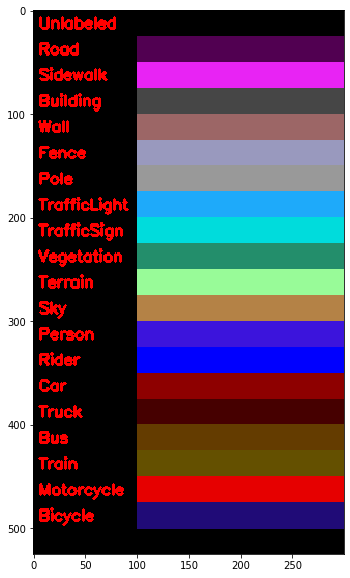

In [35]:
# load the class label names
CLASSES = open(args["classes"]).read().strip().split("\n")

# initialize the legend visualization
legend = np.zeros(((len(CLASSES) * 25) + 25, 300, 3), dtype="uint8")

# loop over the class names + colors
for (i, (className, color)) in enumerate(zip(CLASSES, COLORS)):
	# draw the class name + color on the legend
	color = [int(c) for c in color]
	cv2.putText(legend, className, (5, (i * 25) + 17), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
	cv2.rectangle(legend, (100, (i * 25)), (300, (i * 25) + 25), tuple(color), -1)
display(legend)

[INFO] loading model...
[INFO] inference took 0.1771 seconds
[INFO] inference took 0.1653 seconds
[INFO] inference took 0.1965 seconds
[INFO] inference took 0.1827 seconds


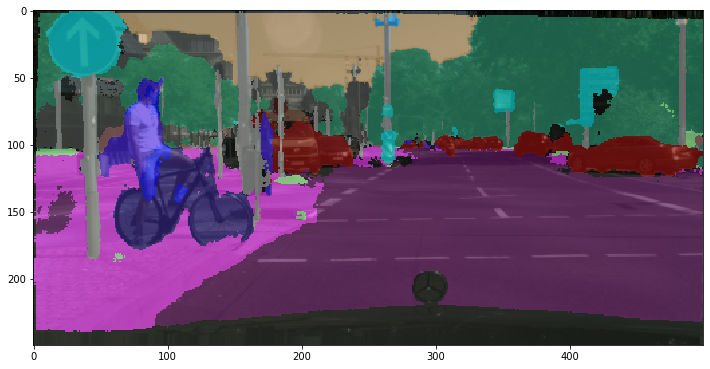

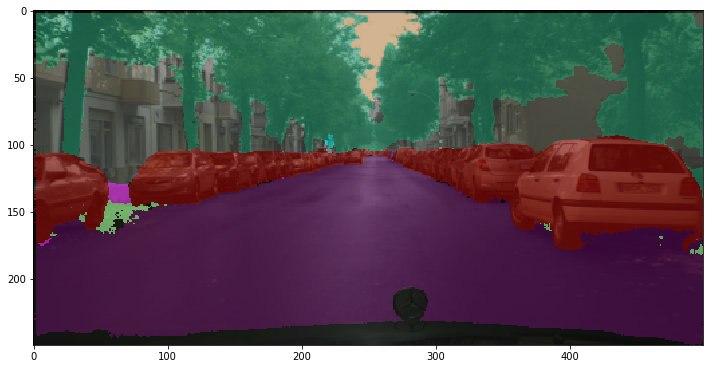

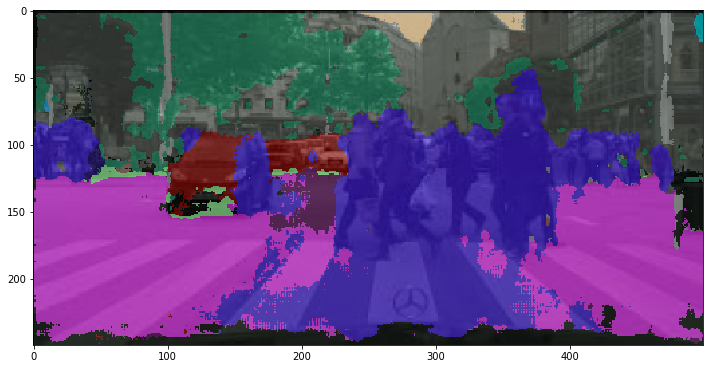

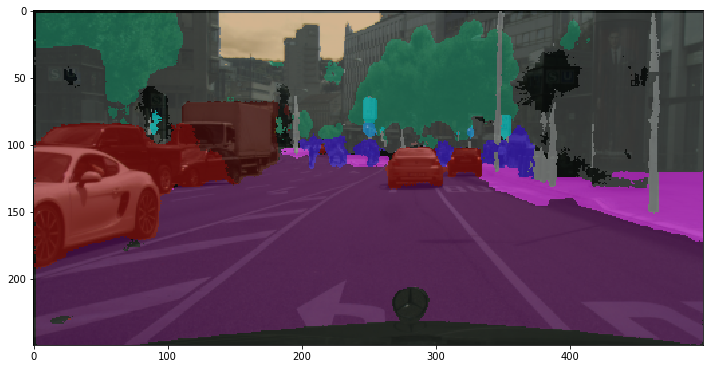

In [36]:
# load our serialized model from disk
print("[INFO] loading model...")
net = cv2.dnn.readNet(args["model"])

for img in images:
	# load the input image, resize it, and construct a blob from it,
	# but keeping mind mind that the original input image dimensions
	# ENet was trained on was 1024x512
	image = cv2.imread(img)
	image = imutils.resize(image, width=args["width"])
	blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (1024, 512), 0,swapRB=True, crop=False)

	# perform a forward pass using the segmentation model
	net.setInput(blob)
	start = time.time()
	output = net.forward()
	end = time.time()

	# show the amount of time inference took
	print("[INFO] inference took {:.4f} seconds".format(end - start))

	# infer the total number of classes along with the spatial dimensions
	# of the mask image via the shape of the output array
	(numClasses, height, width) = output.shape[1:4]

	# our output class ID map will be num_classes x height x width in
	# size, so we take the argmax to find the class label with the
	# largest probability for each and every (x, y)-coordinate in the
	# image
	classMap = np.argmax(output[0], axis=0)

	# given the class ID map, we can map each of the class IDs to its
	# corresponding color
	mask = COLORS[classMap]

	# resize the mask and class map such that its dimensions match the
	# original size of the input image (we're not using the class map
	# here for anything else but this is how you would resize it just in
	# case you wanted to extract specific pixels/classes)
	mask = cv2.resize(mask, (image.shape[1], image.shape[0]),interpolation=cv2.INTER_NEAREST)
	classMap = cv2.resize(classMap, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

	# perform a weighted combination of the input image with the mask to
	# form an output visualization
	output = ((0.4 * image) + (0.6 * mask)).astype("uint8")
	display(output)